# Cats vs. Dogs Class dataset for multiple annotators


## Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import os
import time
import sys

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# os.chdir('/content/drive/Shareddrives/Multiple Anotators/CrowdLayer/Notebooks')
# cwd = os.getcwd()
# sys.path.append("../Models")


# from Multiple_Annotators_C import MultipleAnnotators_Classification

#import sys
#sys.path.insert(1, '../input/multiple-annotators-c/')
#os.chdir('/Multiple Anotators-c/')
#cwd = os.getcwd()
#sys.path.append('/input/multiple-annotators-c')
#from Multiple_Annotators_C import MultipleAnnotators_Classification

# seed_value= 12321 
# from numpy.random import seed
# seed(seed_value)
# tf.random.set_seed(seed_value)

## Download and Prepare the Dataset

We will use the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset and we can load it via Tensorflow Datasets. The images are labeled 0 for cats and 1 for dogs.

# Multiple annotators model

In [4]:

validation_data = tf.data.experimental.load('/kaggle/input/cat-vs-dog-ma-sin/cats_dogs_Te')
train_data_MA = tf.data.experimental.load('/kaggle/input/cat-vs-dog-ma-sin/cats_dogs_MA_sin_Tr_1')



2023-01-03 14:53:06.276756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 14:53:06.362089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 14:53:06.362908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 14:53:06.364520: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
image_count = tf.data.experimental.cardinality(train_data_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count

18610

In [6]:
image_count1 = tf.data.experimental.cardinality(validation_data).numpy() # los datos de training son 18610
image_count1

4652

In [7]:
#X_test = [validation_data[i][0] for i in range(image_count1)]
#Y_true_test = [validation_data[i][1] for i in range(image_count1)]
Y_true_test = np.asarray([aux[1].numpy() for aux  in validation_data])
X_test = np.asarray([aux[0].numpy() for aux  in validation_data])

2023-01-03 14:53:09.071429: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [8]:
image_count

18610

In [9]:
val_size = int(image_count * 0.2)
train_ds_MA = train_data_MA.skip(val_size)
val_ds_MA = train_data_MA.take(val_size)

In [10]:
batch_size = 128
train_batches_MA = train_ds_MA.shuffle(1024).batch(batch_size)
val_batches_MA = val_ds_MA.shuffle(1024).batch(batch_size)
test_batches_MA = validation_data.shuffle(1024).batch(batch_size)

In [11]:
image_count = tf.data.experimental.cardinality(train_ds_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count

14888

In [12]:
image_count_val = tf.data.experimental.cardinality(val_ds_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count_val

3722

2023-01-03 14:53:38.834532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1024
2023-01-03 14:53:42.181053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


annotator 1
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85        60
         1.0       0.89      0.84      0.86        68

    accuracy                           0.86       128
   macro avg       0.86      0.86      0.86       128
weighted avg       0.86      0.86      0.86       128

annotator 2
              precision    recall  f1-score   support

         0.0       0.54      0.62      0.57        60
         1.0       0.61      0.53      0.57        68

    accuracy                           0.57       128
   macro avg       0.57      0.57      0.57       128
weighted avg       0.58      0.57      0.57       128

annotator 3
              precision    recall  f1-score   support

         0.0       0.52      0.45      0.48        60
         1.0       0.57      0.63      0.60        68

    accuracy                           0.55       128
   macro avg       0.54      0.54      0.54       128
weighted avg       0.54      0.55     

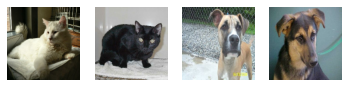

In [13]:
from sklearn.metrics import classification_report
i = 0
fig, ax = plt.subplots(1, 4)
for image, label, label2 in train_batches_MA.take(4):
   # predictedLabel = int(predictions[i] >= 0.5)
   # print(label2)
    ax[i].axis('off')
   # ax[i].set_title(classNames[label[i]])
    ax[i].imshow(image[0])
    i += 1
    for j in range(label2.shape[1]):
      print('annotator',j+1)
      print(classification_report(label ,label2[:,j]))
plt.show()

## Build the classifier from multiple annotators

In [14]:
import tensorflow_datasets as tfds
import tensorflow as tf
import time
from tensorflow.keras import regularizers

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model

class MultipleAnnotators_Classification():
    def __init__(self, output_dim, num_annotators, q= 0.0001):
        self.K = output_dim
        self.R = num_annotators
        self.q = q
        #self.callbacks #=callbacks
        #self.l1_param=l1_param 
        #self.l2_param=l1_param

    def CrowdLayer(self, input):
       #x = keras.layers.Dense(self.R + self.K, kernel_regularizer=regularizers.L1L2(l1= 1e-2, l2=1e-3),  activation='tanh')(input)
        output_cla = keras.layers.Dense(self.K,  activation='softmax')(input)
        output_ann = keras.layers.Dense(self.R,  activation='sigmoid')(input)
        output = keras.layers.Concatenate()([output_cla, output_ann])
        
        return output
#RCDNN   
    def loss(self):
        def custom_loss(y_true, y_pred):
            # print(y_true,y_pred)
            pred = y_pred[:, :self.K]
            pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1-1e-9) #estabilidad numerica de la funcion de costo
            ann_ = y_pred[:, self.K:]
            Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
            Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)
            p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
            temp1 = ann_*tf.math.log(p_logreg)  
            temp2 = (1 - ann_)*tf.math.log(1/self.K)*tf.reduce_sum(Y_true,axis=1)
            # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
            # print(tf.reduce_mean(Y_true,axis=1).numpy())
            return -tf.math.reduce_sum((temp1 + temp2))
        return custom_loss
    
#     def loss(self):
#         def custom_loss(y_true, y_pred):
#                # print(y_true,y_pred)
#            # q = 0.1
#             pred = y_pred[:, :self.K]
#             pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
#             ann_ = y_pred[:, self.K:]
#             # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
#             Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
#             Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

#             p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
#             temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)
#             temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
#             return tf.math.reduce_sum((temp1 + temp2))
#         return custom_loss

    @tf.function
    def train_step(self, x, Y, y):
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)
            loss_value = self.loss_fn(Y, logits)
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_acc_metric.update_state(y, logits[:, :self.K])
        return loss_value

    @tf.function
    def test_step(self, x, y):
        val_logits = self.model(x, training=False)
        self.val_acc_metric.update_state(y, val_logits[:,:self.K])

    def fit(self, model, Data_tr, Data_Val, epochs):
        self.model = model
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # Instantiate an optimizer.
        #self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
        self.optimizer =  tf.keras.optimizers.Adam(learning_rate=1e-3)
        #self.optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, clipnorm=1.0)
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # Instantiate a loss function.
        self.loss_fn = self.loss()
        self.train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
        self.val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

        train_loss = np.zeros(epochs)
        train_accur = np.zeros(epochs)
        val_accur = np.zeros(epochs)
        val_loss = np.zeros(epochs)

        for epoch in range(epochs):
            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train, Y_batch_train) in enumerate(Data_tr):
                # print(y_batch_train, Y_batch_train)
                loss_value = self.train_step(x_batch_train, Y_batch_train, y_batch_train)

                # Log every 200 batches.
                if step % 10 == 0:
                    train_acc = self.train_acc_metric.result()
                    print(
                      "Training loss (for one batch) at step %d: %.4f, Accuracy: %.4f"
                      % (step, float(loss_value), float(train_acc))
                            )
                # print("Seen so far: %d samples" % ((step + 1) * batch_size))



            # Run a validation loop at the end of each epoch.
            for x_batch_val, y_batch_val,Y_batch_val in Data_Val:

                val_logits = model(x_batch_val, training=False)

                val_loss_value = self.loss_fn(Y_batch_val, val_logits)

                self.val_acc_metric.update_state(y_batch_val, val_logits[:,:self.K])
                
               # np.round(np.mean([model(x_batch_val, training= True) for sample in range(100)]), 2)


             # Display metrics at the end of each epoch.
            train_acc = self.train_acc_metric.result()
            val_acc = self.val_acc_metric.result()


            print('---- Training ----')
            print("Training loss: %.4f" % (float(loss_value),))
            print("Training acc over epoch: %.4f" % (float(train_acc),))
            # Reset training metrics at the end of each epoch
            self.train_acc_metric.reset_states()
            self.val_acc_metric.reset_states()


            train_loss[epoch] = float(loss_value)
            train_accur[epoch] = float(train_acc)

            val_accur[epoch] = float(val_acc)
            val_loss[epoch] = float(val_loss_value) 


            print('---- Validation ----')
            print("Validation loss: %.4f" % (float(val_loss_value),))
            print("Validation acc: %.4f" % (float(val_acc),))

            print("Time taken: %.2fs" % (time.time() - start_time))

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Loss and accuracy')
        ax1.plot(range(1,epochs+1),train_loss)
        ax1.plot(range(1,epochs+1), val_loss)
        ax2.plot(range(1,epochs+1),train_accur)
        ax2.plot(range(1,epochs+1),val_accur)
        #plt.figure(figsize=(16,9))
        ax1.set(xlabel= 'Epoch', ylabel="Loss")
        ax2.set(xlabel= 'Epoch',ylabel="Accuracy")
        ax1.legend(['Training_loss', 'Validation_loss'])
        ax2.legend(['Training', 'Validation'])
        ax1.grid()
        ax2.grid()
        plt.show()
        return self.model

    def eval_model(self, Data):
        self.val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
        for x_batch_val, y_batch_val in Data:
            self.test_step(x_batch_val, y_batch_val)

        val_acc = self.val_acc_metric.result()
        self.val_acc_metric.reset_states()
        return val_acc






In [15]:
def custom_loss(y_true, y_pred):
  # print(y_true,y_pred)
  K = 2 #len(np.unique(y_true))
  R = 5
  q = 0.1
  pred = y_pred[:, K]
  pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
  ann_ = y_pred[:,  K:]
  # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
  Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=K, axis=1)
  Y_hat = tf.repeat(tf.expand_dims(pred,-1), R, axis = -1)

  p_gcce = Y_true*(1 - Y_hat**q)/q
  temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)
  temp2 = (1 - ann_)*(1-(1/K)**q)/q*tf.reduce_sum(Y_true,axis=1)
  return tf.math.reduce_sum((temp1 + temp2))



In [16]:
MA = MultipleAnnotators_Classification(2, 5, 0.001)
 
def create_model():
   
    l1 = 1e-2
    # Block 1
    inputs = keras.layers.Input(shape=(150, 150, 3), name='entrada')
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.Conv2D(32, (3, 3), activation="relu" , name="block1_conv1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool")(x)


    # Block 2
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, (3, 3), activation="relu", name="block2_conv1")(x)
    x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block2_pool")(x)

    # Block 3
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation="relu", name="block3_conv1" )(x)             
    x = keras.layers.BatchNormalization()(x)
   # x = keras.layers.Dropout(0.2)(x)
   
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block3_pool")(x)
    
    # Block 4
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation="relu", name="block4_conv1")(x)            
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block4_pool")(x)
    #x = keras.layers.Dropout(0.2)(x)
    
    #x = keras.layers.GlobalAveragePooling2D()(x)
   
    x = keras.layers.Flatten()(x)
    #x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    output = MA.CrowdLayer(x)
    model = keras.Model(inputs=inputs,outputs=output)

    return model


  
  

In [17]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
#     ModelCheckpoint('model1.h5', verbose=1, save_best_only=True, save_weights_only=True)
# ]

In [18]:
# classification_report_r= []
# model = create_model()
# K=2
# R=5
# NUM_RUNS = 5
# N_EPOCHS = 30
# val_acc = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS):
#   MA = MultipleAnnotators_Classification(K, R, 0.1)
#   model = create_model()
#   optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
#   model.compile(optimizer=optimizer, loss= MA.loss())
#   history_model = model.fit(train_batches_MA, validation_data=val_batches_MA, epochs= N_EPOCHS, callbacks=callbacks, verbose=0)
#   #model = MA.fit(model, Data_train_MA, N_EPOCHS)
#   pred_2 = model.predict(X_test)

#   lambda_R_ = pred_2[:, K:] #annotators reliability prediction N x R   
#   classification_report_r += [classification_report( pred_2[:,:K].argmax(axis=1),Y_true_test.ravel(),output_dict=True)]
#   print(classification_report( pred_2[:,:K].argmax(axis=1),Y_true_test.ravel()))
#   #val_acc[i] = MA.eval_model(test_batches_MA)
#   #print("Validation acc: %.4f" % (float(val_acc[i]),))
#   # Create the history figure
#   plt.figure(figsize=(16,9))
#   for i in  history_model.history:
#       plt.plot(history_model.history[i],label=i)
#   plt.title('Model history')
#   plt.legend()
#   plt.grid()

# import pandas as pd
# df = pd.DataFrame(val_acc)
# #df.to_csimport pandas as pddf = pd.DataFrame(val_acc)#df.to_csv('/kaggle/working/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output​v('/kaggle/working/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output



Start of epoch 0


2023-01-03 14:53:47.888254: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Training loss (for one batch) at step 0: 644.5963, Accuracy: 0.6172
Training loss (for one batch) at step 10: 580.3276, Accuracy: 0.5298
Training loss (for one batch) at step 20: 548.0957, Accuracy: 0.5212
Training loss (for one batch) at step 30: 514.1437, Accuracy: 0.5144
Training loss (for one batch) at step 40: 498.6020, Accuracy: 0.5139
Training loss (for one batch) at step 50: 485.4148, Accuracy: 0.5115
Training loss (for one batch) at step 60: 487.1341, Accuracy: 0.5120
Training loss (for one batch) at step 70: 484.5093, Accuracy: 0.5151
Training loss (for one batch) at step 80: 474.6805, Accuracy: 0.5146
Training loss (for one batch) at step 90: 467.6777, Accuracy: 0.5155
Training loss (for one batch) at step 100: 472.0956, Accuracy: 0.5122
Training loss (for one batch) at step 110: 464.2170, Accuracy: 0.5106
---- Training ----
Training loss: 142.5707
Training acc over epoch: 0.5117
---- Validation ----
Validation loss: 34.6058
Validation acc: 0.5032
Time taken: 69.29s

Start o

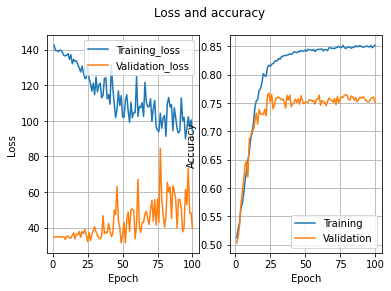

Validation acc: 0.7582
Validation AUC: 0.7579

Start of epoch 0


2023-01-03 15:13:18.232967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1024
2023-01-03 15:13:22.412206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 948 of 1024
2023-01-03 15:13:22.717810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Training loss (for one batch) at step 0: 671.9108, Accuracy: 0.5859
Training loss (for one batch) at step 10: 569.5750, Accuracy: 0.5071
Training loss (for one batch) at step 20: 512.8024, Accuracy: 0.5242
Training loss (for one batch) at step 30: 508.6638, Accuracy: 0.5144
Training loss (for one batch) at step 40: 496.6340, Accuracy: 0.5088
Training loss (for one batch) at step 50: 485.4901, Accuracy: 0.5060
Training loss (for one batch) at step 60: 482.8073, Accuracy: 0.5074
Training loss (for one batch) at step 70: 489.3416, Accuracy: 0.5036
Training loss (for one batch) at step 80: 490.7483, Accuracy: 0.5073
Training loss (for one batch) at step 90: 479.4775, Accuracy: 0.5076
Training loss (for one batch) at step 100: 466.0163, Accuracy: 0.5077
Training loss (for one batch) at step 110: 455.5159, Accuracy: 0.5061
---- Training ----
Training loss: 150.8723
Training acc over epoch: 0.5038
---- Validation ----
Validation loss: 34.4487
Validation acc: 0.4906
Time taken: 34.05s

Start o

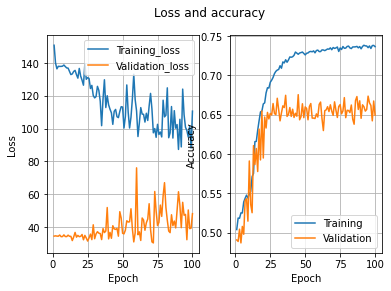

Validation acc: 0.6305
Validation AUC: 0.6336

Start of epoch 0
Training loss (for one batch) at step 0: 663.7021, Accuracy: 0.4688
Training loss (for one batch) at step 10: 569.3007, Accuracy: 0.5064
Training loss (for one batch) at step 20: 582.1025, Accuracy: 0.5138
Training loss (for one batch) at step 30: 521.5743, Accuracy: 0.5096
Training loss (for one batch) at step 40: 528.0381, Accuracy: 0.5061
Training loss (for one batch) at step 50: 505.9241, Accuracy: 0.5110
Training loss (for one batch) at step 60: 483.9406, Accuracy: 0.5108
Training loss (for one batch) at step 70: 474.0908, Accuracy: 0.5142
Training loss (for one batch) at step 80: 483.3331, Accuracy: 0.5163
Training loss (for one batch) at step 90: 463.5138, Accuracy: 0.5155
Training loss (for one batch) at step 100: 461.5815, Accuracy: 0.5147
Training loss (for one batch) at step 110: 470.1223, Accuracy: 0.5143
---- Training ----
Training loss: 144.7418
Training acc over epoch: 0.5152
---- Validation ----
Validation 

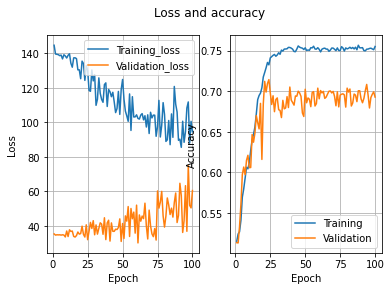

Validation acc: 0.6993
Validation AUC: 0.7005

Start of epoch 0
Training loss (for one batch) at step 0: 635.8860, Accuracy: 0.5469
Training loss (for one batch) at step 10: 593.9790, Accuracy: 0.5241
Training loss (for one batch) at step 20: 551.5685, Accuracy: 0.5208
Training loss (for one batch) at step 30: 519.0139, Accuracy: 0.5197
Training loss (for one batch) at step 40: 505.7303, Accuracy: 0.5183
Training loss (for one batch) at step 50: 487.8184, Accuracy: 0.5159
Training loss (for one batch) at step 60: 502.7401, Accuracy: 0.5160
Training loss (for one batch) at step 70: 477.6386, Accuracy: 0.5141
Training loss (for one batch) at step 80: 462.2960, Accuracy: 0.5136
Training loss (for one batch) at step 90: 472.6207, Accuracy: 0.5154
Training loss (for one batch) at step 100: 469.2187, Accuracy: 0.5148
Training loss (for one batch) at step 110: 463.4043, Accuracy: 0.5155
---- Training ----
Training loss: 143.3799
Training acc over epoch: 0.5146
---- Validation ----
Validation 

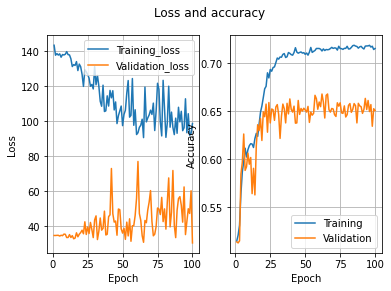

Validation acc: 0.6556
Validation AUC: 0.6586

Start of epoch 0
Training loss (for one batch) at step 0: 602.4993, Accuracy: 0.3750
Training loss (for one batch) at step 10: 607.4537, Accuracy: 0.5064
Training loss (for one batch) at step 20: 571.5861, Accuracy: 0.4963
Training loss (for one batch) at step 30: 521.8425, Accuracy: 0.5169
Training loss (for one batch) at step 40: 497.9319, Accuracy: 0.5103
Training loss (for one batch) at step 50: 501.4322, Accuracy: 0.5106
Training loss (for one batch) at step 60: 467.8735, Accuracy: 0.5086
Training loss (for one batch) at step 70: 473.5103, Accuracy: 0.5100
Training loss (for one batch) at step 80: 464.3617, Accuracy: 0.5113
Training loss (for one batch) at step 90: 470.9391, Accuracy: 0.5085
Training loss (for one batch) at step 100: 460.7297, Accuracy: 0.5080
Training loss (for one batch) at step 110: 464.6620, Accuracy: 0.5108
---- Training ----
Training loss: 144.7425
Training acc over epoch: 0.5085
---- Validation ----
Validation 

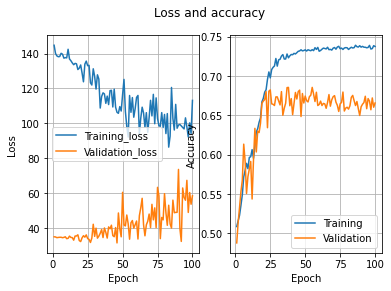

Validation acc: 0.6651
Validation AUC: 0.6689

Start of epoch 0
Training loss (for one batch) at step 0: 670.9489, Accuracy: 0.4688
Training loss (for one batch) at step 10: 580.4990, Accuracy: 0.4893
Training loss (for one batch) at step 20: 552.9230, Accuracy: 0.5000
Training loss (for one batch) at step 30: 513.3492, Accuracy: 0.5055
Training loss (for one batch) at step 40: 507.0436, Accuracy: 0.5057
Training loss (for one batch) at step 50: 502.5324, Accuracy: 0.5069
Training loss (for one batch) at step 60: 484.1464, Accuracy: 0.5068
Training loss (for one batch) at step 70: 484.7224, Accuracy: 0.5097
Training loss (for one batch) at step 80: 487.4322, Accuracy: 0.5068
Training loss (for one batch) at step 90: 465.6000, Accuracy: 0.5060
Training loss (for one batch) at step 100: 476.0539, Accuracy: 0.5059
Training loss (for one batch) at step 110: 462.1617, Accuracy: 0.5061
---- Training ----
Training loss: 149.4908
Training acc over epoch: 0.5051
---- Validation ----
Validation 

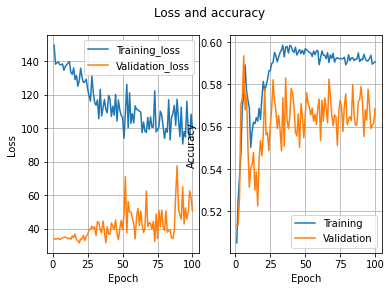

Validation acc: 0.5522
Validation AUC: 0.5595

Start of epoch 0
Training loss (for one batch) at step 0: 610.8853, Accuracy: 0.5000
Training loss (for one batch) at step 10: 606.1340, Accuracy: 0.5064
Training loss (for one batch) at step 20: 553.6683, Accuracy: 0.5037
Training loss (for one batch) at step 30: 531.0156, Accuracy: 0.4952
Training loss (for one batch) at step 40: 512.7643, Accuracy: 0.5002
Training loss (for one batch) at step 50: 513.4720, Accuracy: 0.5005
Training loss (for one batch) at step 60: 479.1627, Accuracy: 0.5006
Training loss (for one batch) at step 70: 491.1385, Accuracy: 0.4986
Training loss (for one batch) at step 80: 476.8503, Accuracy: 0.5002
Training loss (for one batch) at step 90: 487.7534, Accuracy: 0.4985
Training loss (for one batch) at step 100: 466.9946, Accuracy: 0.5005
Training loss (for one batch) at step 110: 466.2692, Accuracy: 0.5013
---- Training ----
Training loss: 143.5549
Training acc over epoch: 0.5020
---- Validation ----
Validation 

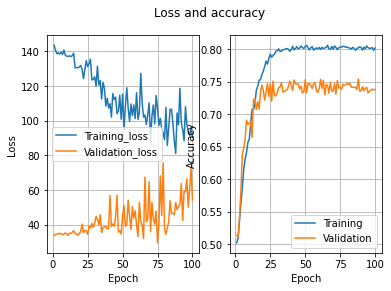

Validation acc: 0.7369
Validation AUC: 0.7374

Start of epoch 0
Training loss (for one batch) at step 0: 629.2925, Accuracy: 0.5000
Training loss (for one batch) at step 10: 557.9579, Accuracy: 0.5057
Training loss (for one batch) at step 20: 524.8480, Accuracy: 0.5160
Training loss (for one batch) at step 30: 524.8962, Accuracy: 0.5219
Training loss (for one batch) at step 40: 499.3623, Accuracy: 0.5183
Training loss (for one batch) at step 50: 493.0009, Accuracy: 0.5153
Training loss (for one batch) at step 60: 483.7955, Accuracy: 0.5193
Training loss (for one batch) at step 70: 473.2819, Accuracy: 0.5235
Training loss (for one batch) at step 80: 472.7347, Accuracy: 0.5235
Training loss (for one batch) at step 90: 478.7380, Accuracy: 0.5223
Training loss (for one batch) at step 100: 461.1266, Accuracy: 0.5208
Training loss (for one batch) at step 110: 468.1353, Accuracy: 0.5189
---- Training ----
Training loss: 140.2579
Training acc over epoch: 0.5189
---- Validation ----
Validation 

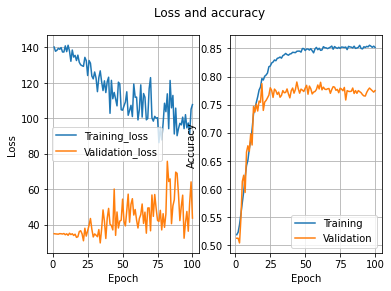

Validation acc: 0.7706
Validation AUC: 0.7714

Start of epoch 0
Training loss (for one batch) at step 0: 677.2673, Accuracy: 0.5234
Training loss (for one batch) at step 10: 581.2394, Accuracy: 0.5071
Training loss (for one batch) at step 20: 579.2819, Accuracy: 0.5078
Training loss (for one batch) at step 30: 555.8775, Accuracy: 0.5073
Training loss (for one batch) at step 40: 532.6993, Accuracy: 0.5061
Training loss (for one batch) at step 50: 492.2612, Accuracy: 0.5057
Training loss (for one batch) at step 60: 490.4420, Accuracy: 0.5092
Training loss (for one batch) at step 70: 478.1641, Accuracy: 0.5059
Training loss (for one batch) at step 80: 494.5961, Accuracy: 0.5082
Training loss (for one batch) at step 90: 470.5297, Accuracy: 0.5076
Training loss (for one batch) at step 100: 483.2734, Accuracy: 0.5077
Training loss (for one batch) at step 110: 464.3497, Accuracy: 0.5076
---- Training ----
Training loss: 144.3322
Training acc over epoch: 0.5085
---- Validation ----
Validation 

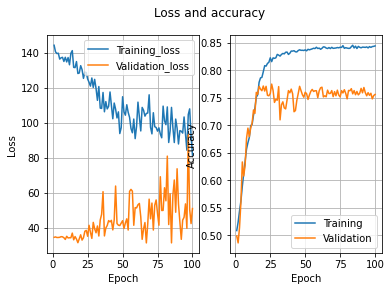

Validation acc: 0.7648
Validation AUC: 0.7640

Start of epoch 0
Training loss (for one batch) at step 0: 670.7859, Accuracy: 0.3984
Training loss (for one batch) at step 10: 622.7382, Accuracy: 0.4858
Training loss (for one batch) at step 20: 575.2712, Accuracy: 0.5011
Training loss (for one batch) at step 30: 542.3860, Accuracy: 0.5023
Training loss (for one batch) at step 40: 507.1797, Accuracy: 0.5051
Training loss (for one batch) at step 50: 499.2445, Accuracy: 0.5083
Training loss (for one batch) at step 60: 508.9822, Accuracy: 0.5120
Training loss (for one batch) at step 70: 506.2785, Accuracy: 0.5124
Training loss (for one batch) at step 80: 487.1513, Accuracy: 0.5102
Training loss (for one batch) at step 90: 482.4382, Accuracy: 0.5110
Training loss (for one batch) at step 100: 475.3534, Accuracy: 0.5134
Training loss (for one batch) at step 110: 473.2705, Accuracy: 0.5137
---- Training ----
Training loss: 151.4904
Training acc over epoch: 0.5135
---- Validation ----
Validation 

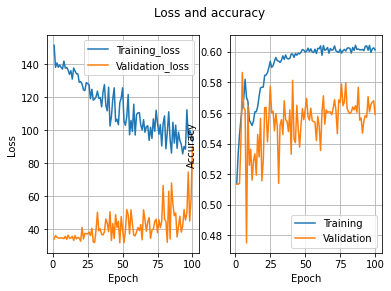

Validation acc: 0.5522
Validation AUC: 0.5588


In [19]:
#model = create_model()
K=2
R=5
NUM_RUNS = 10
N_EPOCHS = 100
val_acc = np.zeros(NUM_RUNS)
AUC= np.zeros(NUM_RUNS)

for i in range(NUM_RUNS):
  MA = MultipleAnnotators_Classification(2, 5, 0.1)
  model =  create_model()
  model = MA.fit(model, train_batches_MA, val_batches_MA, N_EPOCHS)
  #model = MA.fit(model, Data_train_MA, N_EPOCHS)
  val_acc[i] = MA.eval_model(test_batches_MA)
  print("Validation acc: %.4f" % (float(val_acc[i]),))
    
 #AUC =======================
  val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)
  for x_batch_val, y_batch_val in test_batches_MA:
      val_logits = model(x_batch_val.numpy(), training=False)
      # tf.print(y_batch_val)
      val_AUC_metric.update_state(y_batch_val, val_logits[:,:K].numpy().argmax(axis=1).astype('float'))

  val_AUC = val_AUC_metric.result()
  val_AUC_metric.reset_states()
  val_AUC = val_AUC.numpy()
  print("Validation AUC: %.4f" % (float(val_AUC),))
  AUC[i] = val_AUC
  #===================================================

import pandas as pd
df = pd.DataFrame(val_acc)
#df.to_csv('/content/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output

In [20]:
val_acc

array([0.75816852, 0.63048154, 0.69926912, 0.65563196, 0.66509026,
       0.5522356 , 0.73688734, 0.77063626, 0.76483232, 0.5522356 ])

In [21]:
AUC

array([0.75788254, 0.63359034, 0.70049107, 0.6586358 , 0.66890585,
       0.55950713, 0.7374053 , 0.77141839, 0.76399177, 0.5587756 ])

In [22]:
print('Average Accuracy: ', np.round(val_acc.mean(),4)*100) 
print('Average std: ',np.round(np.std(val_acc),4)*100)


Average Accuracy:  67.85
Average std:  7.8100000000000005


In [23]:
print('Average Accuracy: ', np.round( AUC.mean(),4)*100) 
print('Average std: ',np.round(np.std( AUC),4)*100)

Average Accuracy:  68.11
Average std:  7.5600000000000005


In [24]:
# # accuracy
# val_acc_GCCE  = np.zeros(NUM_RUNS)

# for i in range(len(classification_report_r)):
   
#   val_acc_GCCE[i] = classification_report_r[i]['accuracy']


In [25]:
val_acc

array([0.75816852, 0.63048154, 0.69926912, 0.65563196, 0.66509026,
       0.5522356 , 0.73688734, 0.77063626, 0.76483232, 0.5522356 ])

In [26]:
print('Average Accuracy: ', np.round(val_acc.mean(),4)*100) 

Average Accuracy:  67.85


In [27]:
# y_test = np.asarray([aux[1].numpy() for aux  in validation_data])
# X_test = np.asarray([aux[0].numpy() for aux  in validation_data])
# # N = len(y_true)
# # #test_batches_MA
# # aux1 = [test_batches_MA[i][0] for i in range(N)]
# # aux2 = [test_batches_MA[i][1] for i in range(N)]

In [28]:
# X_test.shape

In [29]:
# pred = model.predict(X_test)
# pred[:, :2].argmax(axis=1)
# print(classification_report(pred[:, :2].argmax(axis=1), y_test ))


In [30]:
val_acc.mean()

0.6785468518733978

In [31]:
print('STD Accuracy: ', np.round(np.std(val_acc),4)*100) 

STD Accuracy:  7.8100000000000005


MC droput run this in a loop with training layer set to True.

In [32]:
# y_probas = np.stack([MA.eval_model((test_batches,training=True) # se activa training en True para que el Dropout se aplique
#                    for sample in range(100)])

# y_proba = y_probas.mean(axis=0)
# y_std = y_probas.std(axis=0)
# y_probas.shape

In [33]:
# y_ped =np.argmax(y_proba,axis=1)
# accuracy=np.sum(y_pred==test_label)/len(test_label)
# accuracy

In [34]:
   
# r1 = np.mean(val_acc)
# print("\nMean: ", r1)
  
# r2 = np.std(val_acc)
# print("\nstd: ", r2)
  
# r3 = np.var(val_acc)
# print("\nvariance: ", r3)
# #MA.eval_model(test_batches)

In [35]:
# val_acc

VGG19 --> acc:0.8613  --> 0.894454 --> 0.772356